*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall23/notebooks/module03_02_linear_regression.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)

# Linear Regression

*Adapted from Chapter 3 of [An Introduction to Statistical Learning](https://www.statlearning.com/)*

### Regression problems

The two primary types of machine learning problems we will focus on in this course are:

* **Classification problems:** supervised learning problems with a categorical label
* **Regression problems**: supervised learning problems with a continuous label

In this notebook we will learn one of the simplest methods for regression, namely **linear regression**.

Why learn linear regression?

- Fast
- Easy to use
- Interpretable
- Basis for many other methods


### The advertising data

To illustrate the concept of linear regression we will use a dataset that describes product sales as a function of advertising.

What are the examples?

- Each example represents a product in a given market (total number of examples:  200).

What are the features?

- **TV:** advertising dollars spent on TV ads 
- **radio:** advertising dollars spent on radio ads
- **newspaper:** advertising dollars spent on newspaper ads

All expenditures are in thousands of dollars.

What are the labels?

- **sales:** sales of a product in a given market (in thousands of widgets)


In [2]:
# read data into a pandas DataFrame
import pandas as pd
data = pd.read_csv('https://www.statlearning.com/s/Advertising.csv',index_col=0)
data.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
len(data)

200

### How can you help?

You are asked by the company: On the basis of this data, how should we spend our advertising money?

As their machine learning / data scientist, you offer more specific help:

* Is there a relationship between ads and sales?
* How strong is that relationship?
* Which ad types contribute to sales?
* What is the effect of each ad type on sales?
* Given ad spending in a particular market, can sales be predicted?


### Visualizing the data

We'll use a **scatter plot** to visualize the relationship between the features and the labels.

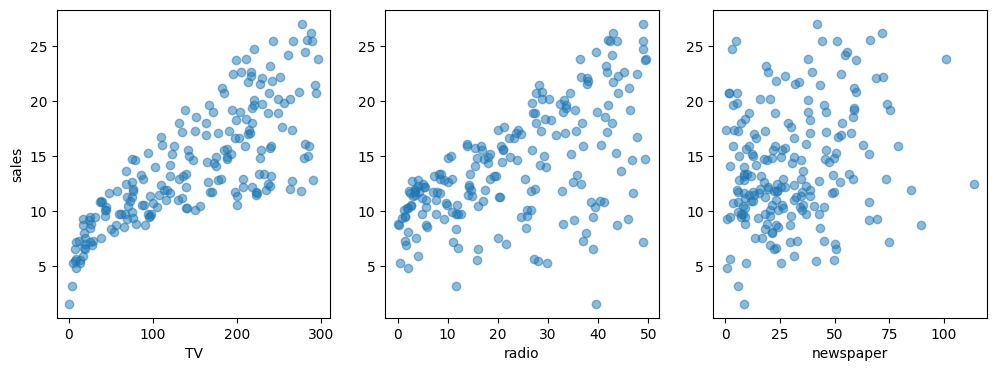

In [4]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12, 4))
ax1.scatter(data['TV'], data['sales'], alpha=0.5)
ax1.set_xlabel('TV')
ax1.set_ylabel('sales')
ax2.scatter(data['radio'], data['sales'], alpha=0.5)
ax2.set_xlabel('radio')
ax3.scatter(data['newspaper'], data['sales'], alpha=0.5)
ax3.set_xlabel('newspaper');

These figures show that there is a relationship between these features and the labels, and some features appear to be more predictive of the response (the label, $y$). We can quantify the strength of the relationships between variables by computing the correlation matrix:

In [5]:
# compute the correlation matrix
data.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


### A Deeper Dive into Correlation

If you are looking for a rough English phrase to loosely describe correlation try this: correlation measures how much one variable's movements track the movements of another.  

Moving toward a more formal definition, correlation quantifies the strength of the **linear** relationship between two variables.  


Here's a figure that illustrates the concept:
![correlation figure from wikipedia](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)



Informed applied data analysts use the concept of correlation constantly and develop an intuition for the measure. Our goal here is to give you some additional geometric intuition for correlation that may or may not be part of most people's tool box. 

To start, here is the equation that defines the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between two random variables $X$ and $Y$ with observed samples $(x_1,\ldots,x_n)$ and $(y_1,\ldots,y_n)$:

$$
r_{xy} = \frac{\sum_{i=1}^{n}{(x_i} - \bar{x})(y_i - \bar{y})}
            {\sqrt{\sum_{i=1}^{n}{(x_i - \bar{x})^2}\sum_{i=1}^{n}{(y_i - \bar{y})^2}}}.
$$

Here $\bar{x}$ and $\bar{y}$ are the means of $X$ and $Y$, respectively.  Although we typically use the letter $y$ to denote labels, the $Y$ here can be any variable of interest.
We can take this definition and relate it to something we already understand - dot products!

First, let's look closely at the numerator in the equation above.  What you see is the average of each vector $\bar{x}$ is being subtracted from each sample.  What would happen if $\bar{x}$ and $\bar{y}$ were both zero?  The numerator would reduce to:

$$
\sum_{i=1}^{n}{x^{\prime}_i y^{\prime}_i}, ~~\mathrm{where}~~
       \;\;\; x_i^{\prime} = x_i - \bar{x}, \;y_i^{\prime} = y_i - \bar{y}
$$

In words, the numerator is just the dot product between the mean subtracted vectors.

Now look at the denominator:

$$
\sqrt{\sum_{i=1}^{n}{(x_i - \bar{x})^2}\sum_{i=1}^{n}{(y_i - \bar{y})^2}}
$$

Let's express it using our mean-subtracted vectors:

$$
\sqrt{\sum_{i=1}^{n}{(x_i^\prime)^2}\sum_{i=1}^{n}{(y_i^\prime)^2}}
$$


Finally, let's express the correlation in terms of the mean-subtracted vectors:

$$
r_{xy} = \sum_{i=1}^n \frac{x_i^\prime}{\sqrt{\sum_{j=1}^{n}{(x^{\prime}_j)^2}}} \frac{y_i^\prime}{\sqrt{\sum_{j=1}^{n}{(y^{\prime}_j)^2}}}
$$

In the denominators we have the magnitude of the mean-subtracted vectors, i.e. what we have here is the dot product between two unit vectors, i.e. the cosine of the angle between the mean subtracted vectors!  This both gives us a geometric intuition about correlation, and also tells us that its magnitude is between -1 and 1.

Let's demonstrate that on the sales data

In [6]:
# create feature matrix and vector of labels
X = data[['TV']].values
y = data['sales'].values
X.shape, y.shape

((200, 1), (200,))

In [7]:
# create feature matrix and vector of labels
X = data[['TV']].values
y = data['sales'].values

x = X[:,0]
x_centered = x - np.mean(x)
y_centered = y - np.mean(y)
(x_centered / np.linalg.norm(x_centered)) @ \
    (y_centered / np.linalg.norm(y_centered))

0.7822244248616067

Let's verify the result with the NumPy implementation:

In [8]:
np.corrcoef(x, y)

array([[1.    , 0.7822],
       [0.7822, 1.    ]])


### Linear regression on the advertising data

Next, we will use scikit-learn to perform linear regression to predict sales:

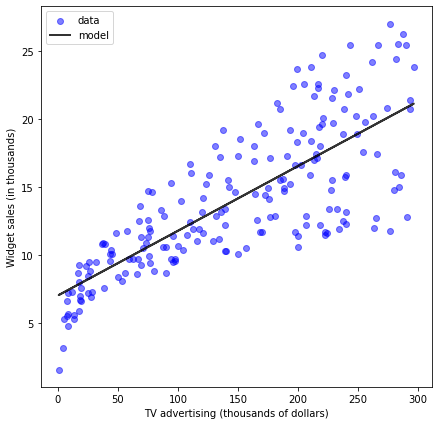

In [9]:
from sklearn.linear_model import LinearRegression

# instantiate, fit, and predict:
linreg = LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(X)

# plot the reslts
fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(111)

ax.scatter(X, y,  color='blue', alpha=0.5, label = 'data')
ax.plot(X, y_pred, color='black', alpha=0.8,linewidth=2, label = 'model')
ax.set_xlabel('TV advertising (thousands of dollars)')
ax.set_ylabel('Widget sales (in thousands)')
ax.legend(loc="best");

### Linear regression in one dimension

In one dimension, linear regression takes the following form:

$$y =  wx + b$$

where:

- $y$ is the label
- $x$ is the feature
- $b$ is the bias, or intercept in this case
- $w$ is the parameter corresponding to x

The variables $w$ and $b$ are the **model parameters**, which are learned during the training process.  The resulting model can then be used to predict the label, which in the context of regression, is also called the *response*.


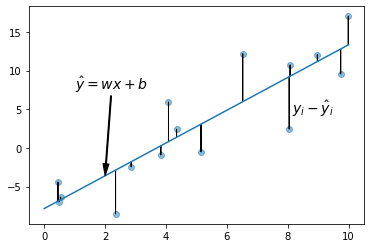

In [10]:
# create some random data
from numpy.random import default_rng
num_examples = 15
rng = default_rng(5)
x = 10 * rng.random(num_examples)
y = 2 * x - 5 + rng.standard_normal(num_examples)* 5

# instantiate and fit
model = LinearRegression()
model.fit(x[:, np.newaxis], y)

# data for plotting the regression line
xs = np.linspace(0, 10, 1000)
ys = model.predict(xs[:, np.newaxis])

# plot the regression line
plt.scatter(x, y, alpha=0.5)
plt.plot(xs, ys)

# the predictions over the training data
y_hat = model.predict(x[:, np.newaxis])

for i in range(len(x)):
    plt.arrow(x[i],y_hat[i], 0, y[i]-y_hat[i])
plt.text(x[0]+0.1, y[0]+2, r'$y_i-\hat{y}_i$', fontsize = 14);
plt.annotate(r'$\hat{y} = wx + b$', fontsize=14, xy=(xs[200], ys[200]), 
             xytext=(xs[400]-3, ys[400]+7),
             arrowprops=dict(facecolor='black',width=1,headwidth=6));

### Learning the model 

In the figure above:

- The dots are the **observed values** of x and y.
- The blue line is the **least squares line**.
- The black lines are the **residuals**, which are the distances between the observed values and the least squares line.  These are used to compute the **sum of squared error**.

Coefficients are estimated during the model fitting process using the **least squares criterion**.

How do the model parameters relate to the least squares line?

- $w$ is the **slope**
- $b$ is the **intercept** (the value of $y$ when $x$=0)

The parameters $(w,b)$ are chosen as to minimize the sum-squared error:
$$
J( w,b ) = \sum_{i=1}^N (y_i - \hat{y}_i)^2,
$$

where $y_i$ are the known labels and $\hat{y}_i = w x_i + b$ are the predicted labels.

### Interpreting model parameters

The regression coefficient $w$ which corresponds to the TV feature has the following interpretation:

- A unit increase in TV ad spending is associated with an increase of $w$ units in sales.
- This is not a statement of **causation**.

If an increase in TV ad spending was associated with a **decrease** in sales, $w$ would be **negative**.

Let's test this out on the advertising data:

In [9]:
# create X and y
X = data[['TV']].values
y = data['sales'].values

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

w = linreg.coef_[0]
b = linreg.intercept_

# print the coefficients
print(f'The w model parameter is {w:.3f}')
print(f'The b model parameter is {b:.3f}')

sales_100 = w * 100 + b
sales_200 = w * 200 + b
print('Increasing TV advertising from 100 to 200 increases predicted sales'+
      f' from {sales_100:.1f} to {sales_200:.1f} thousand widgets')

# plot the reslts
fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(111)

ax.scatter(X, y,  color='blue', alpha=0.5, label = 'data')
ax.plot(X, y_pred, color='black', alpha=0.8,linewidth=2, label = 'model')
ax.set_xlabel('TV advertising (thousands of dollars)')
ax.set_ylabel('Widget sales (in thousands)')
ax.legend(loc="best");

NameError: name 'LinearRegression' is not defined

### Using the model for prediction

Let's say that there was a new market where the TV advertising budget was **$50,000**. What would be the predicted sales in that market?


In [12]:
# compute using the formula w * x + b:
linreg.coef_[0] * 50 + linreg.intercept_

9.409425570778682

In [13]:
# or using the predict method:
linreg.predict(np.array([[50]]))

array([9.4094])